In [243]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from datetime import date
import datetime
from bs4 import BeautifulSoup
import requests
import pandas as pd
from datetime import date
import datetime
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from  time import sleep

In [244]:
import sys
sys.path.insert(1, '/content/drive/MyDrive/unit7/')
from config import * # config.py

In [245]:
!pip install spotipy

In [246]:
import spotipy
import json
from spotipy.oauth2 import SpotifyClientCredentials

In [247]:
# Connect to spotify
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= my_spotify_clientid,
                                                           client_secret= my_spotify_clientsecret))

In [248]:
# Find spotify playlists
def find_users_playlist(username):
    playlists = sp.user_playlists(username)
    playlist_uri = []
    while playlists:
        for i, playlist in enumerate(playlists['items']):
            playlist_uri.append(playlist['uri'])
        if playlists['next']:
            playlists = sp.next(playlists)
        else:
            playlists = None
    return playlist_uri

In [249]:
# Get songs and feautures from playlists
def get_audio_features(username,playlist_uri):
    features_dict = {}
    for playlist in playlist_uri:
        results = sp.user_playlist_tracks(username,playlist)
        tracks = results['items']
        while results['next']:
            results = sp.next(results)
            tracks.extend(results['items'])
        for track in tracks:
            afeatures = sp.audio_features(track["track"]["uri"])
            features_dict[track['track']['name']] = afeatures
    return features_dict

In [250]:
#my_list = find_users_playlist('1170594511')
my_list = find_users_playlist('sheilabrugman')

In [251]:
#all_audio = get_audio_features('1170594511',my_list)
all_audio = get_audio_features('sheilabrugman',my_list)

In [252]:
#df_sp = pd.json_normalize(all_audio['Poor Boy'])
df_sp = pd.json_normalize(all_audio['Miracle'])
for song in all_audio.keys():
    try:
        x = pd.json_normalize(all_audio[song])
        df_sp = pd.concat([df_sp, x], ignore_index=True)
    except:
        x = None

In [253]:
df_sp

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.540,0.474,11,-8.272,1,0.0330,0.47900,0.000007,0.0949,0.185,130.200,audio_features,22hw67NtsSmWCkCFCIVWNO,spotify:track:22hw67NtsSmWCkCFCIVWNO,https://api.spotify.com/v1/tracks/22hw67NtsSmW...,https://api.spotify.com/v1/audio-analysis/22hw...,270333,4
1,0.803,0.631,5,-8.323,0,0.0482,0.23100,0.887000,0.0985,0.391,121.996,audio_features,0LDxYtcNpdJTYn0e1XXWJR,spotify:track:0LDxYtcNpdJTYn0e1XXWJR,https://api.spotify.com/v1/tracks/0LDxYtcNpdJT...,https://api.spotify.com/v1/audio-analysis/0LDx...,348258,4
2,0.690,0.964,10,-5.121,0,0.0560,0.00419,0.907000,0.2410,0.246,123.997,audio_features,4wjjoEdPT6a5f2BGMnpOBX,spotify:track:4wjjoEdPT6a5f2BGMnpOBX,https://api.spotify.com/v1/tracks/4wjjoEdPT6a5...,https://api.spotify.com/v1/audio-analysis/4wjj...,214839,4
3,0.807,0.962,5,-5.975,0,0.0534,0.00387,0.708000,0.1400,0.772,122.004,audio_features,3cA4x3DnZLk3zBJDisW9DA,spotify:track:3cA4x3DnZLk3zBJDisW9DA,https://api.spotify.com/v1/tracks/3cA4x3DnZLk3...,https://api.spotify.com/v1/audio-analysis/3cA4...,381639,4
4,0.571,0.921,8,-5.363,1,0.0359,0.00123,0.546000,0.0808,0.674,122.984,audio_features,3sBoraxFOxBb2oBcP9458P,spotify:track:3sBoraxFOxBb2oBcP9458P,https://api.spotify.com/v1/tracks/3sBoraxFOxBb...,https://api.spotify.com/v1/audio-analysis/3sBo...,209053,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,0.805,0.798,9,-4.395,1,0.1140,0.22700,0.000000,0.0649,0.693,120.009,audio_features,6fM8nxYwUYzjOCJCp8Uy5F,spotify:track:6fM8nxYwUYzjOCJCp8Uy5F,https://api.spotify.com/v1/tracks/6fM8nxYwUYzj...,https://api.spotify.com/v1/audio-analysis/6fM8...,210195,4
373,0.677,0.929,7,-3.917,0,0.0512,0.04440,0.228000,0.1010,0.205,126.019,audio_features,4vB3s2bUNReIrFFWVT4aN2,spotify:track:4vB3s2bUNReIrFFWVT4aN2,https://api.spotify.com/v1/tracks/4vB3s2bUNReI...,https://api.spotify.com/v1/audio-analysis/4vB3...,284256,4
374,0.673,0.790,7,-4.663,0,0.0893,0.03700,0.000010,0.0875,0.705,102.013,audio_features,7vfWgVGiLgnGbInU5lvSQg,spotify:track:7vfWgVGiLgnGbInU5lvSQg,https://api.spotify.com/v1/tracks/7vfWgVGiLgnG...,https://api.spotify.com/v1/audio-analysis/7vfW...,199227,4
375,0.833,0.582,11,-6.987,0,0.0659,0.05300,0.057700,0.1080,0.209,125.026,audio_features,1tNxprI7wf87blRuXUyEvC,spotify:track:1tNxprI7wf87blRuXUyEvC,https://api.spotify.com/v1/tracks/1tNxprI7wf87...,https://api.spotify.com/v1/audio-analysis/1tNx...,293579,4


In [254]:
df_sp.to_csv('/content/drive/MyDrive/unit7/day3/lab-unsupervised-learning-intro/prototype/dataset/spotify_songs_raw.csv', index = False)

In [255]:
#Reset the index on uri nad drop columns
df_sp = df_sp.set_index(['id'])
df_sp = df_sp.drop(['type', 'uri', 'track_href', 'analysis_url', 'time_signature'], axis=1)

In [256]:
df_sp

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
id,,,,,,,,,,,,
22hw67NtsSmWCkCFCIVWNO,0.540,0.474,11,-8.272,1,0.0330,0.47900,0.000007,0.0949,0.185,130.200,270333
0LDxYtcNpdJTYn0e1XXWJR,0.803,0.631,5,-8.323,0,0.0482,0.23100,0.887000,0.0985,0.391,121.996,348258
4wjjoEdPT6a5f2BGMnpOBX,0.690,0.964,10,-5.121,0,0.0560,0.00419,0.907000,0.2410,0.246,123.997,214839
3cA4x3DnZLk3zBJDisW9DA,0.807,0.962,5,-5.975,0,0.0534,0.00387,0.708000,0.1400,0.772,122.004,381639
3sBoraxFOxBb2oBcP9458P,0.571,0.921,8,-5.363,1,0.0359,0.00123,0.546000,0.0808,0.674,122.984,209053
...,...,...,...,...,...,...,...,...,...,...,...,...
6fM8nxYwUYzjOCJCp8Uy5F,0.805,0.798,9,-4.395,1,0.1140,0.22700,0.000000,0.0649,0.693,120.009,210195
4vB3s2bUNReIrFFWVT4aN2,0.677,0.929,7,-3.917,0,0.0512,0.04440,0.228000,0.1010,0.205,126.019,284256
7vfWgVGiLgnGbInU5lvSQg,0.673,0.790,7,-4.663,0,0.0893,0.03700,0.000010,0.0875,0.705,102.013,199227


In [257]:
import pickle
import joblib

In [258]:
# Fit the scaler
scaler = StandardScaler().fit(df_sp)

In [259]:
pickle.dump(scaler, open('/content/drive/MyDrive/unit7/day3/lab-unsupervised-learning-intro/prototype/scaler.pickle', 'wb'))

In [260]:
# Fit and transform the dataframe
X_prep = StandardScaler().fit_transform(df_sp)

In [261]:
pd.DataFrame(X_prep, columns=df_sp.columns)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,-0.742292,-0.834390,1.583136,-0.132513,0.891761,-0.585573,0.956155,-0.571909,-0.519872,-1.353573,0.485610,0.104465
1,0.856543,-0.096287,-0.088691,-0.145789,-1.121376,-0.415405,0.068121,2.182808,-0.496750,-0.538216,0.138788,0.442924
2,0.169591,1.469245,1.304498,0.687753,-1.121376,-0.328082,-0.744036,2.244921,0.418462,-1.112133,0.223380,-0.136568
3,0.880860,1.459842,-0.088691,0.465440,-1.121376,-0.357190,-0.745182,1.626891,-0.230215,0.969798,0.139126,0.587911
4,-0.553836,1.267089,0.747222,0.624756,0.891761,-0.553107,-0.754635,1.123771,-0.610430,0.581910,0.180555,-0.161699
...,...,...,...,...,...,...,...,...,...,...,...,...
372,0.868701,0.688830,1.025860,0.876744,0.891761,0.321241,0.053798,-0.571929,-0.712548,0.657113,0.054788,-0.156738
373,0.090561,1.304699,0.468585,1.001177,-1.121376,-0.381820,-0.600053,0.136165,-0.480694,-1.274412,0.308859,0.164938
374,0.066244,0.651219,0.468585,0.806979,-1.121376,0.044719,-0.626551,-0.571898,-0.567398,0.704609,-0.705989,-0.204377
375,1.038920,-0.326650,1.583136,0.201997,-1.121376,-0.217250,-0.569258,-0.392732,-0.435736,-1.258580,0.266881,0.205432


In [262]:
kmeans = KMeans(n_clusters=5,
                init="random", 
                n_init=3,  # try with 1, 4, 8, 20, 30, 100...
                max_iter=2,
                tol=0,
                algorithm="full",
                random_state=1234)
kmeans.fit(X_prep)
print(kmeans.inertia_)

2930.3405731787725


In [263]:
clusters = kmeans.predict(X_prep)
pd.Series(clusters).value_counts().sort_index()

0     51
1     45
2    117
3     76
4     88
dtype: int64

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

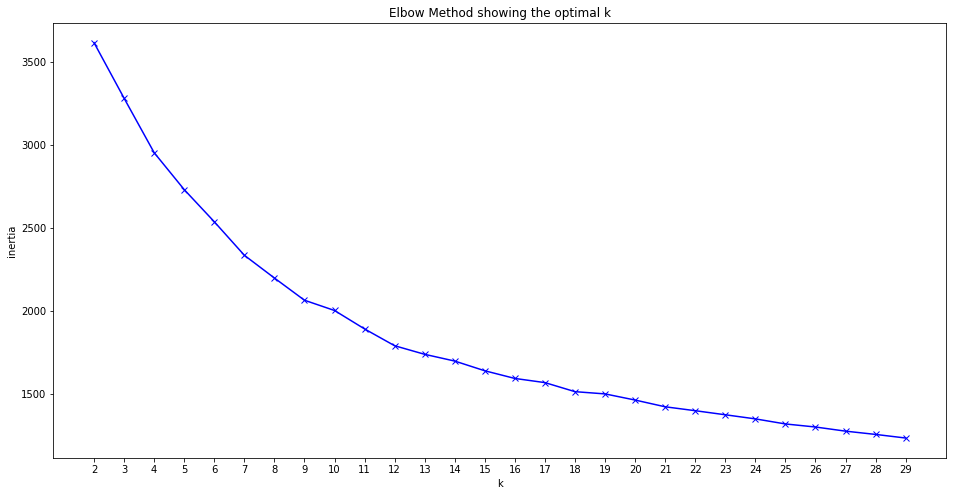

In [264]:
K = range(2, 30)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_prep)
    inertia.append(kmeans.inertia_)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

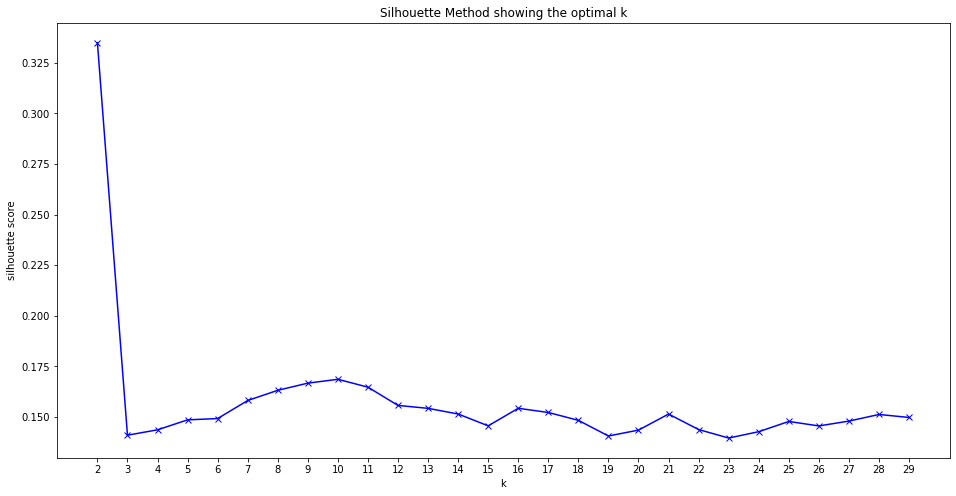

In [265]:
K = range(2, 30)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_prep)
    silhouette.append(silhouette_score(X_prep, kmeans.predict(X_prep)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')

In [266]:
# TEST 2
kmeans = KMeans(n_clusters=20,
                n_init=5,  # try with 1, 4, 8, 20, 30, 100...
                max_iter=10,
                tol=0,
                algorithm="full",
                random_state=1234)
kmeans.fit(X_prep)
print(kmeans.inertia_)

1476.8311691718059


In [ ]:
# TEST 2 K-Means
K = range(2, 20)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                n_init=5,  # try with 1, 4, 8, 20, 30, 100...
                max_iter=10,
                tol=0,
                algorithm="full",
                random_state=1234)
    kmeans.fit(X_prep)
    inertia.append(kmeans.inertia_)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

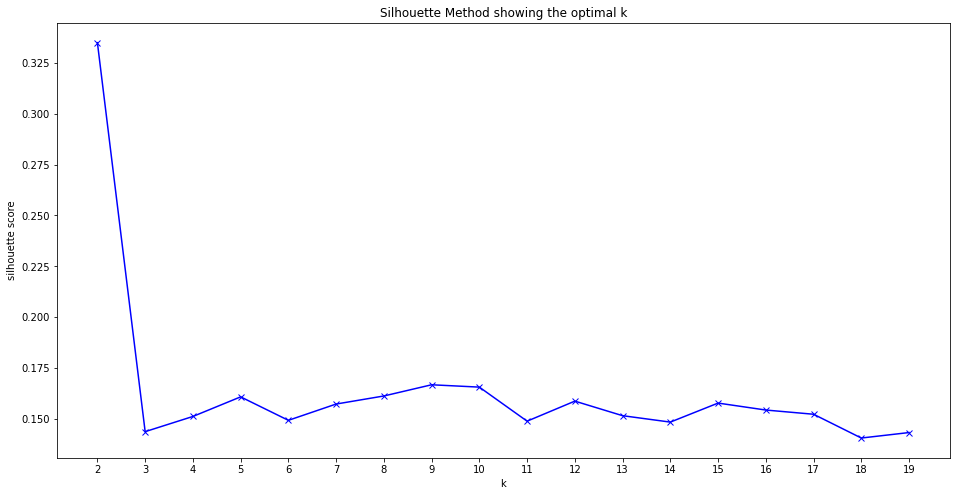

In [268]:
# TEST 2 Silhouette
K = range(2, 20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                n_init=5,  # try with 1, 4, 8, 20, 30, 100...
                max_iter=10,
                tol=0,
                random_state=1234)
    kmeans.fit(X_prep)
    silhouette.append(silhouette_score(X_prep, kmeans.predict(X_prep)))

plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')

In [269]:
# Chosing k= 9
model = KMeans(n_clusters=9, random_state=1234).fit(X_prep)

In [270]:
# Save the model
joblib.dump(model, '/content/drive/MyDrive/unit7/day3/lab-unsupervised-learning-intro/prototype/model.pkl')  
model_loaded = joblib.load('/content/drive/MyDrive/unit7/day3/lab-unsupervised-learning-intro/prototype/model.pkl')

In [271]:
# fit model and predict clusters
y_pred = model.predict(X_prep)

In [272]:
pd.Series(y_pred).value_counts().sort_index()

0    24
1    63
2    34
3    98
4     1
5    53
6    64
7    22
8    18
dtype: int64

In [273]:
cluster_df = pd.DataFrame(X_prep)
cluster_df['cluster'] = y_pred
cluster_df

,0,1,2,3,4,5,6,7,8,9,10,11,cluster
0,-0.742292,-0.834390,1.583136,-0.132513,0.891761,-0.585573,0.956155,-0.571909,-0.519872,-1.353573,0.485610,0.104465,2
1,0.856543,-0.096287,-0.088691,-0.145789,-1.121376,-0.415405,0.068121,2.182808,-0.496750,-0.538216,0.138788,0.442924,5
2,0.169591,1.469245,1.304498,0.687753,-1.121376,-0.328082,-0.744036,2.244921,0.418462,-1.112133,0.223380,-0.136568,5
3,0.880860,1.459842,-0.088691,0.465440,-1.121376,-0.357190,-0.745182,1.626891,-0.230215,0.969798,0.139126,0.587911,5
4,-0.553836,1.267089,0.747222,0.624756,0.891761,-0.553107,-0.754635,1.123771,-0.610430,0.581910,0.180555,-0.161699,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,0.868701,0.688830,1.025860,0.876744,0.891761,0.321241,0.053798,-0.571929,-0.712548,0.657113,0.054788,-0.156738,1
373,0.090561,1.304699,0.468585,1.001177,-1.121376,-0.381820,-0.600053,0.136165,-0.480694,-1.274412,0.308859,0.164938,3
374,0.066244,0.651219,0.468585,0.806979,-1.121376,0.044719,-0.626551,-0.571898,-0.567398,0.704609,-0.705989,-0.204377,3
375,1.038920,-0.326650,1.583136,0.201997,-1.121376,-0.217250,-0.569258,-0.392732,-0.435736,-1.258580,0.266881,0.205432,3


In [274]:
cluster_df.to_csv('/content/drive/MyDrive/unit7/day3/lab-unsupervised-learning-intro/prototype/dataset/spotify_songs.csv', index = False)


In [275]:
df_hot_list = pd.read_csv('/content/drive/MyDrive/unit7/day3/lab-unsupervised-learning-intro/prototype/dataset/hot_songs.csv')
df_hot_list.head()

,song,artist,year
0,heat waves,Glass Animals,2020
1,booster seat,Spacey Jane,2020
2,the difference,Flume and Toro y Moi,2020
3,cherub,Ball Park Music,2020
4,lost in yesterday,Tame Impala,2020


In [276]:
import random

In [289]:
# Function for getting audio features of user input song from Spotify
def get_song_features(song_title):
    chosen_song = sp.search(q=song_title, limit=50) 
    chosen_song["tracks"]["items"][0]["uri"]
    my_dict = sp.audio_features(chosen_song["tracks"]["items"][0]["uri"])[0]
    return my_dict

In [291]:
# Function for getting the user input song. 
# If song is in hot list, recommend 3 songs from the hot list
# If song is not in hot list, get features of chosen song from Spotify
def get_song_input(cluster_df,df_sp):
#    global song_features
    songlist = df_hot_list['song']
    song_features = []
    song_title = input("Please enter your favorite song: ").lower()
    if not song_title in list(songlist):
        #print("We have no recommendations for you")
        song_features.append(get_song_features(song_title))
        #print('song features:', song_features)
        song_cluster = scale_trans_predict(song_features) #Function to scale song features and to predict the cluster.
        recommend_songs(cluster_df,df_sp, song_cluster)
    else:
        #print("You're favorite song is:", song_title, "\n")
        print("We found some awesome songs for you that yuo probably like:\n", ",  ".join(random.sample(list(songlist), k=3)))
    return song_title

In [292]:
def scale_trans_predict(song_features): 
  df_song_features = pd.DataFrame(song_features, index = [0])
  df_song_features = df_song_features.set_index(['id'])
  df_song_features = df_song_features.drop(['type', 'uri', 'track_href', 'analysis_url', 'time_signature'], axis=1)
  load_scaler = pickle.load(open('/content/drive/MyDrive/unit7/day3/lab-unsupervised-learning-intro/prototype/scaler.pickle', 'rb'))
  model_loaded = joblib.load('/content/drive/MyDrive/unit7/day3/lab-unsupervised-learning-intro/prototype/model.pkl')
  # transform the StandardScaler on chosen song
  song_input_transform = load_scaler.transform(df_song_features)
  # Predict the chosen song
  song_cluster = model_loaded.predict(song_input_transform)
  return song_cluster

In [293]:
def recommend_songs(df,df_sp, song_cluster): 
  indexes = list(df[df['cluster'] == song_cluster[0]].index)
  choice = random.choice(indexes)
  df_new = df_sp.reset_index()
  choice_id = df_new.loc[choice]['id']
  results = sp.track(choice_id)
  song = results['name']
  artist = results['artists'][0]['name']
  print("We found some awesome songs for you that you probably like:\n")
  print('Song:', song, 'by:', artist)

In [ ]:
get_user_input()
if ( user_song in hot_list ):
  recomend_another_song_from_hot_list
else: 
  get_song_features
  get_song_cluster
  filter_dataset_to_song_cluster
  recomend_song as random.coice_of_song_of_the_same_cluster

In [281]:
df_sp.reset_index().head()

,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,22hw67NtsSmWCkCFCIVWNO,0.540,0.474,11,-8.272,1,0.0330,0.47900,0.000007,0.0949,0.185,130.200,270333
1,0LDxYtcNpdJTYn0e1XXWJR,0.803,0.631,5,-8.323,0,0.0482,0.23100,0.887000,0.0985,0.391,121.996,348258
2,4wjjoEdPT6a5f2BGMnpOBX,0.690,0.964,10,-5.121,0,0.0560,0.00419,0.907000,0.2410,0.246,123.997,214839
3,3cA4x3DnZLk3zBJDisW9DA,0.807,0.962,5,-5.975,0,0.0534,0.00387,0.708000,0.1400,0.772,122.004,381639
4,3sBoraxFOxBb2oBcP9458P,0.571,0.921,8,-5.363,1,0.0359,0.00123,0.546000,0.0808,0.674,122.984,209053


# **GNOD Song recommender**

In [299]:
get_song_input(cluster_df,df_sp)

Please enter your favorite song: hello
We found some awesome songs for you that you probably like:

Song: My Old Piano by: Diana Ross


'hello'